In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
from collections import Counter
from tqdm import tqdm

# Add the playground directory to Python path to import the plotting function
sys.path.append('playground')
from plot_dataset_distributions import plot_dataset_distributions

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Configure matplotlib for inline plotting
%matplotlib inline
plt.style.use('default')
plt.rcParams['figure.dpi'] = 100


In [2]:
# Configuration parameters
dataset_files = ["ts1x-val.lmdb", "ts1x-train.lmdb", "RGD1.lmdb", "RGD2.lmdb"]
num_samples = 1000
output_dir = "plots"

print("Analysis Configuration:")
print(f"Datasets to analyze: {dataset_files}")
print(f"Number of samples per dataset: {num_samples}")
print(f"Output directory: {output_dir}")


Analysis Configuration:
Datasets to analyze: ['ts1x-val.lmdb', 'ts1x-train.lmdb', 'RGD1.lmdb', 'RGD2.lmdb']
Number of samples per dataset: 1000
Output directory: plots


In [3]:
# Import required modules for data loading
from gadff.horm.ff_lmdb import LmdbDataset
from gadff.path_config import fix_horm_dataset_path

# Storage for results
all_atom_counts = {}
all_atom_types = {}

# Process each dataset to collect data
for dataset_idx, dataset_file in enumerate(dataset_files):
    print(f"\nProcessing dataset: {dataset_file}")
    
    try:
        # Load dataset
        input_lmdb_path = fix_horm_dataset_path(dataset_file)
        dataset = LmdbDataset(input_lmdb_path)
        print(f"Loaded dataset with {len(dataset)} samples from {input_lmdb_path}")
        
        # Check if dataset has enough samples
        available_samples = len(dataset)
        samples_to_use = min(num_samples, available_samples)
        
        if available_samples < num_samples:
            print(f"Warning: Dataset has only {available_samples} samples, using all of them")
        
        # Get random sample indices
        sample_indices = random.sample(range(available_samples), samples_to_use)
        
        # Extract atom counts and types
        atom_counts = []
        all_atomic_numbers = []
        
        for sample_idx in tqdm(sample_indices, desc=f"Processing {dataset_file}"):
            try:
                sample = dataset[sample_idx]
                n_atoms = sample.pos.shape[0]
                atom_counts.append(n_atoms)
                
                # Extract atomic numbers
                if hasattr(sample, 'atomic_numbers'):
                    atomic_numbers = sample.atomic_numbers.cpu().numpy() if torch.is_tensor(sample.atomic_numbers) else sample.atomic_numbers
                    all_atomic_numbers.extend(atomic_numbers)
                elif hasattr(sample, 'z'):
                    atomic_numbers = sample.z.cpu().numpy() if torch.is_tensor(sample.z) else sample.z
                    all_atomic_numbers.extend(atomic_numbers)
                else:
                    print(f"Warning: No atomic number information found in sample {sample_idx}")
                    
            except Exception as e:
                print(f"Error processing sample {sample_idx} in {dataset_file}: {e}")
                continue
        
        # Store results
        all_atom_counts[dataset_file] = atom_counts
        all_atom_types[dataset_file] = all_atomic_numbers
        
    except Exception as e:
        print(f"Failed to process dataset {dataset_file}: {e}")
        continue

print("\nData collection completed!")



Processing dataset: ts1x-val.lmdb
Loaded dataset with 50844 samples from /home/andreasburger/.cache/kagglehub/datasets/yunhonghan/hessian-dataset-for-optimizing-reactive-mliphorm/versions/5/ts1x-val.lmdb


Processing ts1x-val.lmdb:  67%|██████▋   | 669/1000 [00:01<00:00, 1006.60it/s]

Processing ts1x-val.lmdb: 100%|██████████| 1000/1000 [00:01<00:00, 909.14it/s]



Processing dataset: ts1x-train.lmdb
Failed to process dataset ts1x-train.lmdb: Dataset path ts1x-train.lmdb not found

Processing dataset: RGD1.lmdb
Loaded dataset with 60000 samples from /home/andreasburger/.cache/kagglehub/datasets/yunhonghan/hessian-dataset-for-optimizing-reactive-mliphorm/versions/5/RGD1.lmdb


Processing RGD1.lmdb:   0%|          | 0/1000 [00:00<?, ?it/s]

Processing RGD1.lmdb:  32%|███▎      | 325/1000 [00:00<00:00, 3243.92it/s]

Processing RGD1.lmdb:  65%|██████▌   | 650/1000 [00:00<00:00, 3182.19it/s]

Processing RGD1.lmdb: 100%|██████████| 1000/1000 [00:00<00:00, 3157.44it/s]


Processing dataset: RGD2.lmdb
Failed to process dataset RGD2.lmdb: Dataset path RGD2.lmdb not found

Data collection completed!


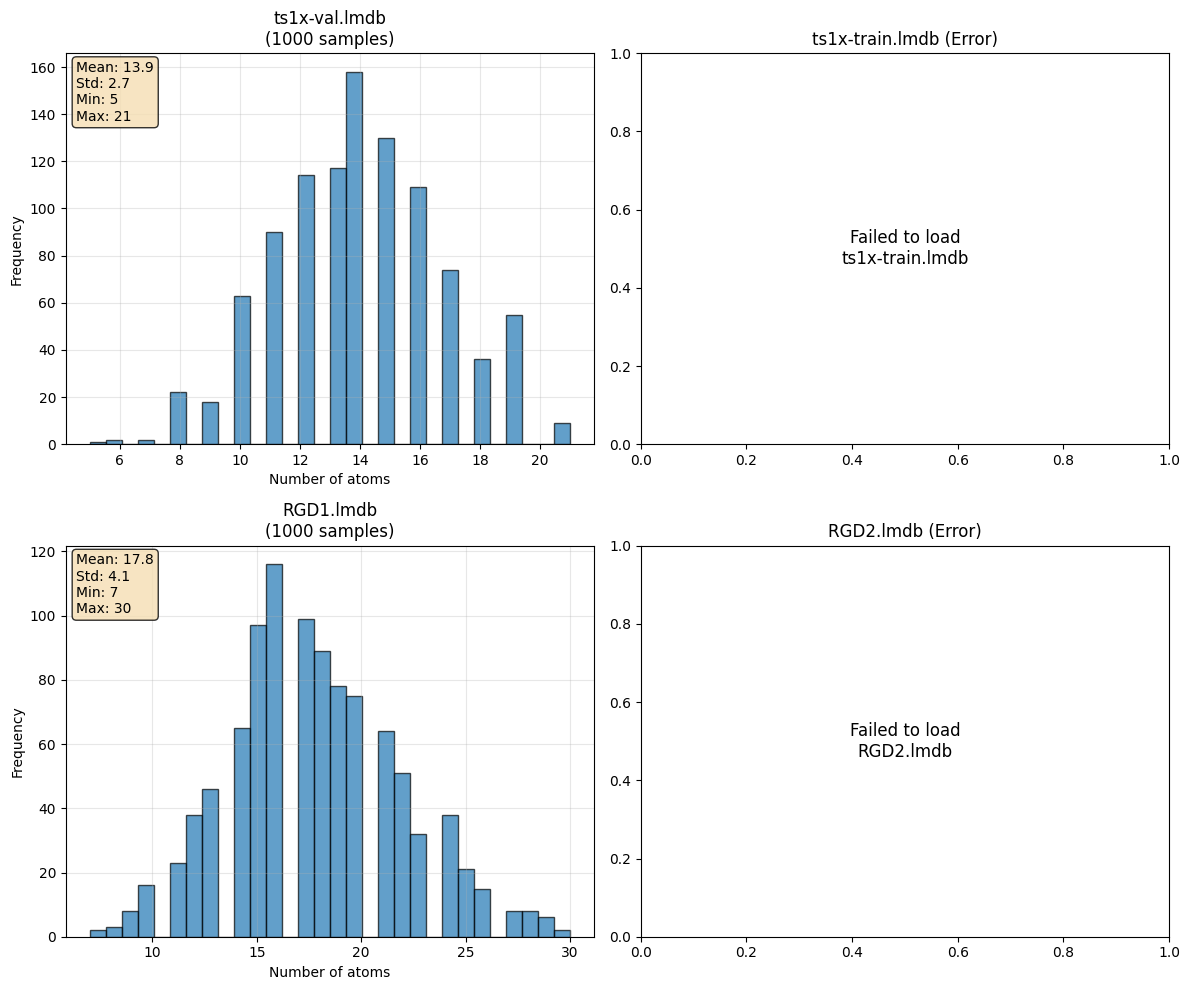

In [4]:
# Import atomic symbols mapping
from plot_dataset_distributions import ATOMIC_SYMBOLS

# Create atom count histograms
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for dataset_idx, dataset_file in enumerate(dataset_files):
    if dataset_file in all_atom_counts:
        atom_counts = all_atom_counts[dataset_file]
        ax = axes[dataset_idx]
        ax.hist(atom_counts, bins=30, alpha=0.7, edgecolor='black')
        ax.set_title(f'{dataset_file}\n({len(atom_counts)} samples)')
        ax.set_xlabel('Number of atoms')
        ax.set_ylabel('Frequency')
        ax.grid(True, alpha=0.3)
        
        # Add statistics text
        if atom_counts:
            stats_text = f'Mean: {np.mean(atom_counts):.1f}\nStd: {np.std(atom_counts):.1f}\nMin: {np.min(atom_counts)}\nMax: {np.max(atom_counts)}'
            ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
                   verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    else:
        ax = axes[dataset_idx]
        ax.text(0.5, 0.5, f'Failed to load\n{dataset_file}', 
               ha='center', va='center', transform=ax.transAxes, fontsize=12)
        ax.set_title(f'{dataset_file} (Error)')

plt.tight_layout()
plt.show()


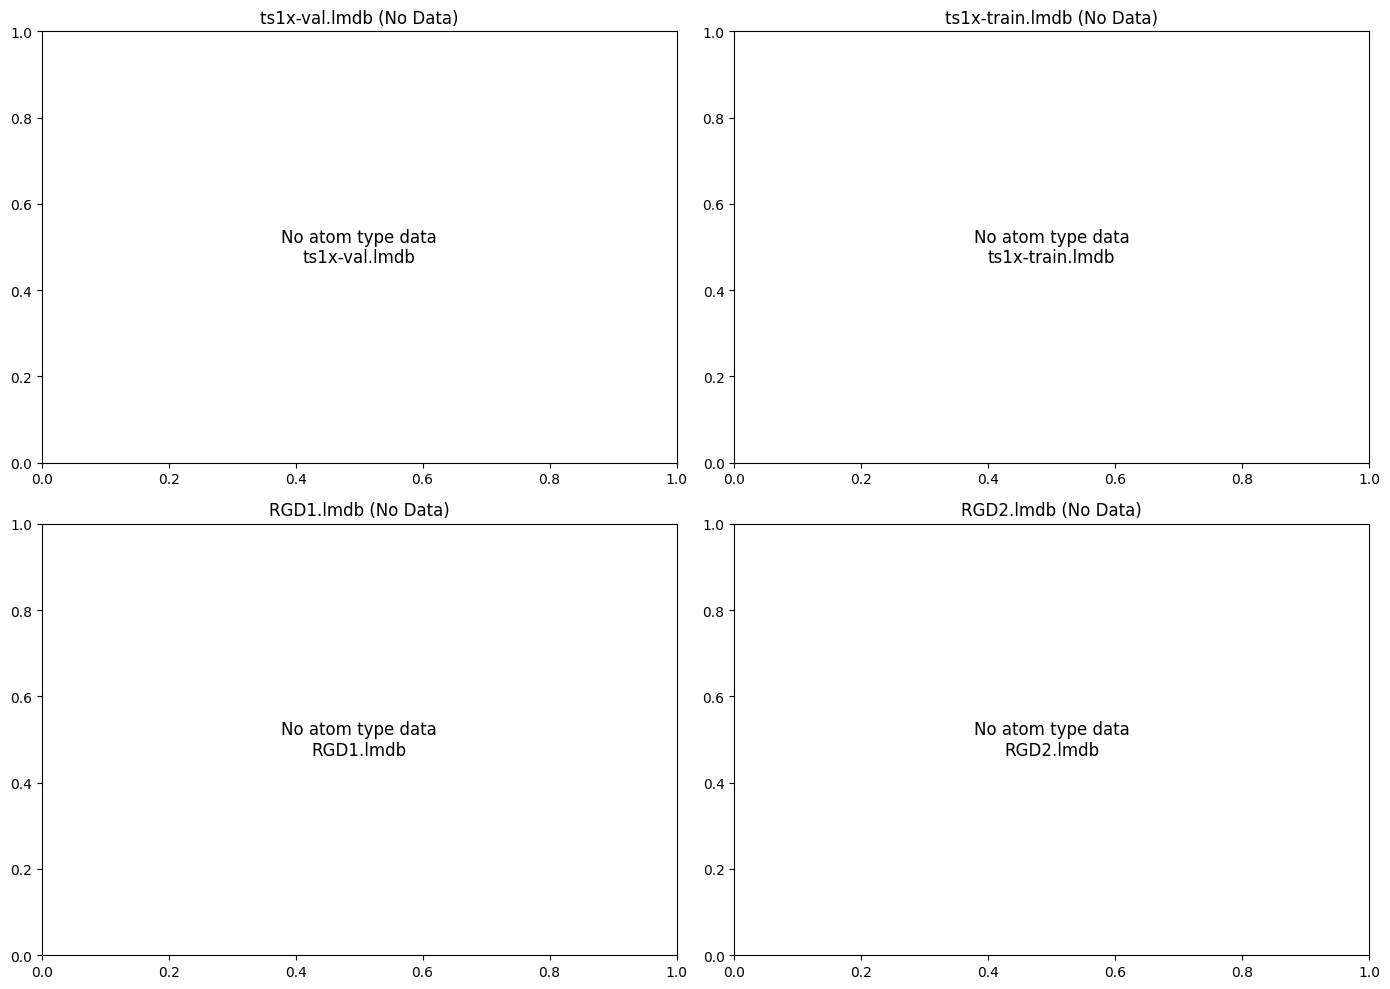

In [5]:
# Create atom type distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for dataset_idx, dataset_file in enumerate(dataset_files):
    if dataset_file in all_atom_types and all_atom_types[dataset_file]:
        atomic_numbers = all_atom_types[dataset_file]
        ax = axes[dataset_idx]
        
        # Count occurrences of each atomic number
        atomic_counter = Counter(atomic_numbers)
        
        # Convert to element symbols
        elements = []
        counts = []
        for atomic_num, count in sorted(atomic_counter.items()):
            element_symbol = ATOMIC_SYMBOLS.get(atomic_num, f'Z{atomic_num}')
            elements.append(element_symbol)
            counts.append(count)
        
        # Create bar plot
        bars = ax.bar(elements, counts, alpha=0.7, edgecolor='black')
        ax.set_title(f'{dataset_file}\nAtom Type Distribution ({len(atomic_numbers)} total atoms)')
        ax.set_xlabel('Element')
        ax.set_ylabel('Count')
        ax.grid(True, alpha=0.3, axis='y')
        
        # Rotate x-axis labels for better readability
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
        
        # Add count labels on bars for smaller datasets
        if len(elements) <= 10:
            for bar, count in zip(bars, counts):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{count}', ha='center', va='bottom', fontsize=8)
    else:
        ax = axes[dataset_idx]
        ax.text(0.5, 0.5, f'No atom type data\n{dataset_file}', 
               ha='center', va='center', transform=ax.transAxes, fontsize=12)
        ax.set_title(f'{dataset_file} (No Data)')

plt.tight_layout()
plt.show()


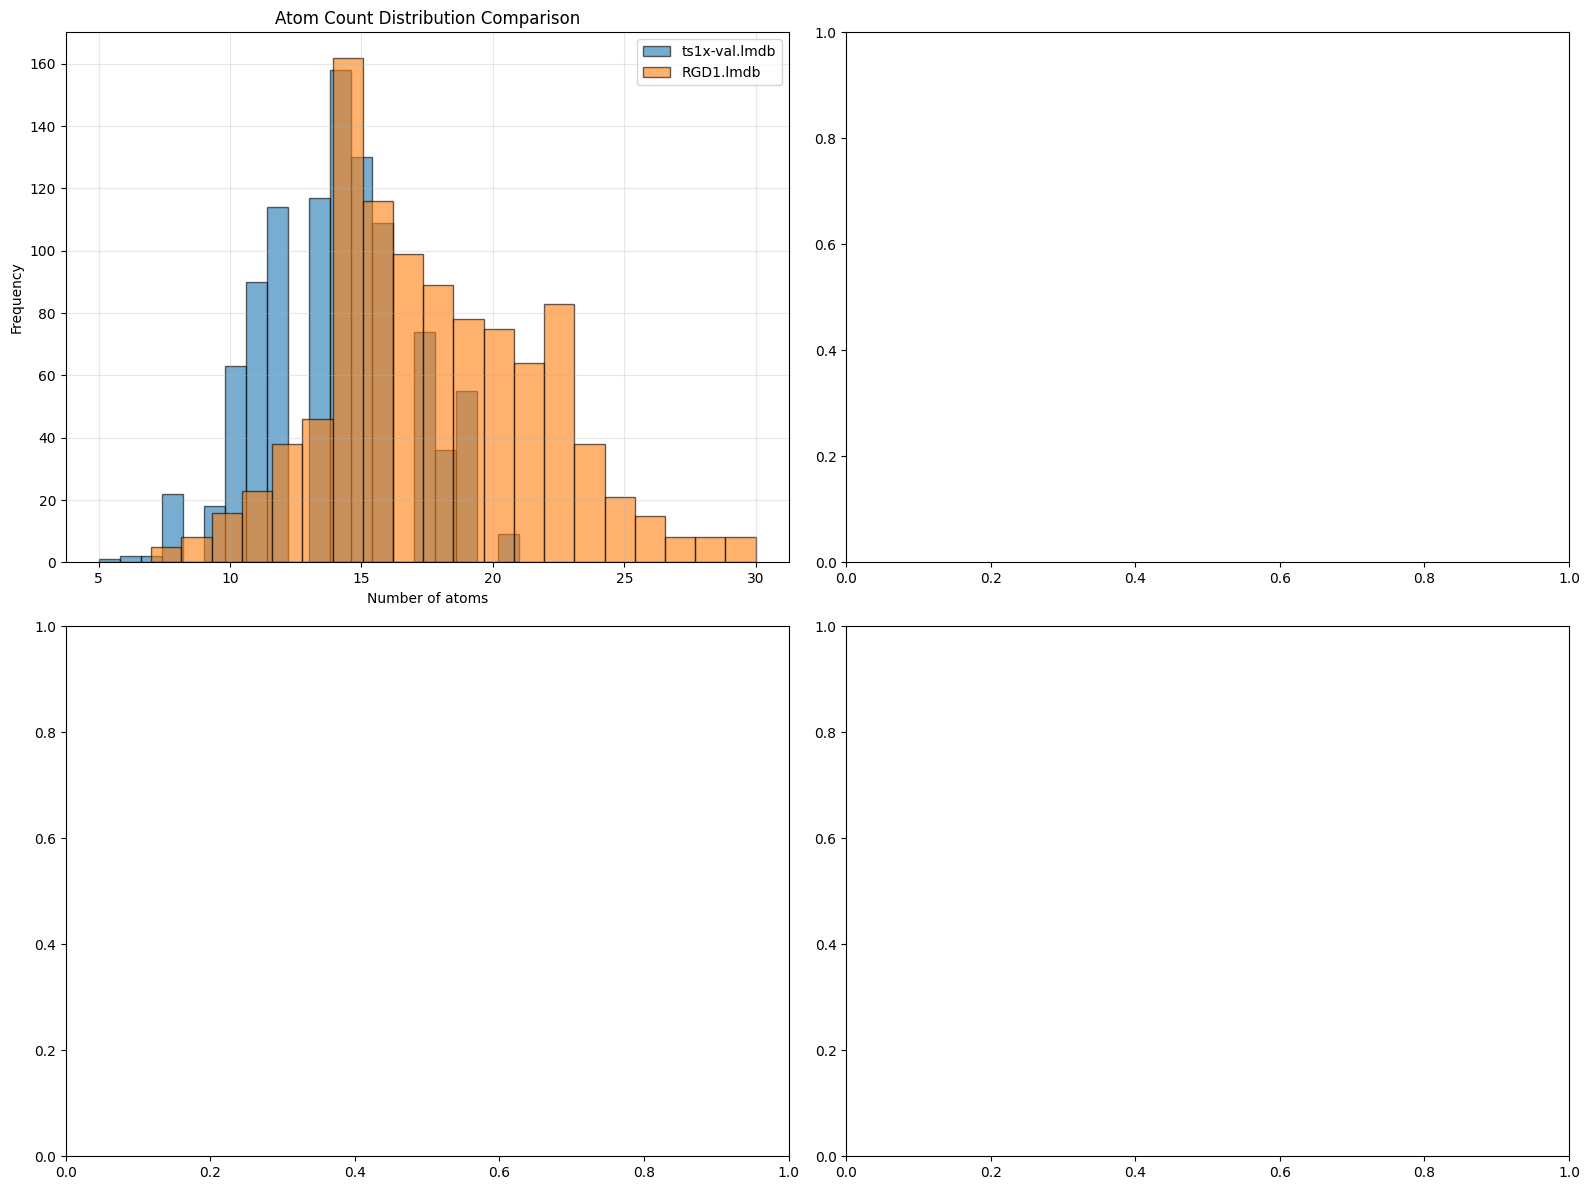

In [6]:
# Create combined summary plot
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Combined atom count histograms
for dataset_file in dataset_files:
    if dataset_file in all_atom_counts:
        atom_counts = all_atom_counts[dataset_file]
        ax1.hist(atom_counts, bins=20, alpha=0.6, label=dataset_file, edgecolor='black')
ax1.set_xlabel('Number of atoms')
ax1.set_ylabel('Frequency')
ax1.set_title('Atom Count Distribution Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Total atoms per dataset
dataset_names = []
total_atoms = []
for dataset_file in dataset_files:
    if dataset_file in all_atom_types and all_atom_types[dataset_file]:
        dataset_names.append(dataset_file.replace('.lmdb', ''))
        total_atoms.append(len(all_atom_types[dataset_file]))

if total_atoms:
    bars = ax2.bar(dataset_names, total_atoms, alpha=0.7, edgecolor='black')
    ax2.set_xlabel('Dataset')
    ax2.set_ylabel('Total Atoms Analyzed')
    ax2.set_title('Total Atoms per Dataset')
    ax2.grid(True, alpha=0.3, axis='y')
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
    
    # Add count labels on bars
    for bar, count in zip(bars, total_atoms):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
               f'{count}', ha='center', va='bottom')

# Plot 3: Element diversity comparison
diversity_data = {}
for dataset_file in dataset_files:
    if dataset_file in all_atom_types and all_atom_types[dataset_file]:
        unique_elements = len(set(all_atom_types[dataset_file]))
        diversity_data[dataset_file.replace('.lmdb', '')] = unique_elements

if diversity_data:
    names = list(diversity_data.keys())
    diversities = list(diversity_data.values())
    bars = ax3.bar(names, diversities, alpha=0.7, edgecolor='black')
    ax3.set_xlabel('Dataset')
    ax3.set_ylabel('Number of Unique Elements')
    ax3.set_title('Element Diversity per Dataset')
    ax3.grid(True, alpha=0.3, axis='y')
    plt.setp(ax3.get_xticklabels(), rotation=45, ha='right')
    
    # Add count labels on bars
    for bar, count in zip(bars, diversities):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
               f'{count}', ha='center', va='bottom')

# Plot 4: Most common elements across all datasets
all_elements_combined = []
for dataset_file in dataset_files:
    if dataset_file in all_atom_types:
        all_elements_combined.extend(all_atom_types[dataset_file])

if all_elements_combined:
    element_counter = Counter(all_elements_combined)
    top_elements = element_counter.most_common(10)
    
    elements = [ATOMIC_SYMBOLS.get(atomic_num, f'Z{atomic_num}') for atomic_num, _ in top_elements]
    counts = [count for _, count in top_elements]
    
    bars = ax4.bar(elements, counts, alpha=0.7, edgecolor='black')
    ax4.set_xlabel('Element')
    ax4.set_ylabel('Total Count (All Datasets)')
    ax4.set_title('Top 10 Most Common Elements')
    ax4.grid(True, alpha=0.3, axis='y')
    plt.setp(ax4.get_xticklabels(), rotation=45, ha='right')
    
    # Add count labels on bars
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
               f'{count}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


In [7]:
# Display detailed results for each dataset
for dataset_file, atom_counts in all_atom_counts.items():
    if atom_counts:
        print(f"\n{'='*50}")
        print(f"Dataset: {dataset_file}")
        print(f"{'='*50}")
        print(f"Samples analyzed: {len(atom_counts)}")
        print(f"Min atoms: {np.min(atom_counts)}")
        print(f"Max atoms: {np.max(atom_counts)}")
        print(f"Mean atoms: {np.mean(atom_counts):.2f}")
        print(f"Std atoms: {np.std(atom_counts):.2f}")
        print(f"Median atoms: {np.median(atom_counts):.2f}")
        
        if dataset_file in all_atom_types and all_atom_types[dataset_file]:
            atomic_numbers = all_atom_types[dataset_file]
            unique_elements = set(atomic_numbers)
            element_symbols = [ATOMIC_SYMBOLS.get(z, f'Z{z}') for z in sorted(unique_elements)]
            print(f"Total atoms: {len(atomic_numbers)}")
            print(f"Unique elements: {len(unique_elements)}")
            print(f"Elements present: {', '.join(element_symbols)}")
            
            # Show top 5 most common elements in this dataset
            element_counter = Counter(atomic_numbers)
            top_5 = element_counter.most_common(5)
            print(f"Top 5 elements:")
            for atomic_num, count in top_5:
                element = ATOMIC_SYMBOLS.get(atomic_num, f'Z{atomic_num}')
                percentage = (count / len(atomic_numbers)) * 100
                print(f"  {element}: {count} atoms ({percentage:.1f}%)")



Dataset: ts1x-val.lmdb
Samples analyzed: 1000
Min atoms: 5
Max atoms: 21
Mean atoms: 13.92
Std atoms: 2.75
Median atoms: 14.00

Dataset: RGD1.lmdb
Samples analyzed: 1000
Min atoms: 7
Max atoms: 30
Mean atoms: 17.77
Std atoms: 4.08
Median atoms: 17.00
